# Extrapolation with f2py

In [1]:
# we need to compile the fortran code into something python can use
!make

f2py -c -m lib_watermass lib_watermass.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "lib_watermass" sources
f2py options: []
f2py:> /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmpjyo9fjrp/src.macosx-10.7-x86_64-3.6/lib_watermassmodule.c
creating /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmpjyo9fjrp/src.macosx-10.7-x86_64-3.6
Reading fortran codes...
	Reading file 'lib_watermass.f90' (format:free)
Post-processing...
	Block: lib_watermass
			Block: volume_watermass_from_ts
			Block: volume_watermass_from_ts_v2
			Block: volume_watermass_from_ts_v3
Post-processing (stage 2)...
Building modules...
	Building module "lib_watermass"...
		Creating wrapper for Fortran subroutine "volume_watermass_from_ts"("volume_watermass_from_ts")...
		Constructing wrapper fun

In [1]:
import xarray as xr
import fill_msg_grid
import numpy as np
%matplotlib inline
from matplotlib import cm
import matplotlib.pylab as plt

In [5]:
byrd=True

In [6]:
# get the World Ocean Atlas annual T/S data

if not byrd:
    # wget in disguise in the Makefile
    #!make getdata # we have this already from example watermasses
    woadir='./'
else:
    # if running on byrd, we are gonna use files stored in ~rdussin/demo_files/
    woadir='~rdussin/demo_files/'

In [7]:
#---------------------------------------------------------------
# sample data set (use make getdata to download WOA annual data)
fnameT = woadir + 'woa13_5564_t00_01.nc'

woa = xr.open_dataset(fnameT,decode_times=False)

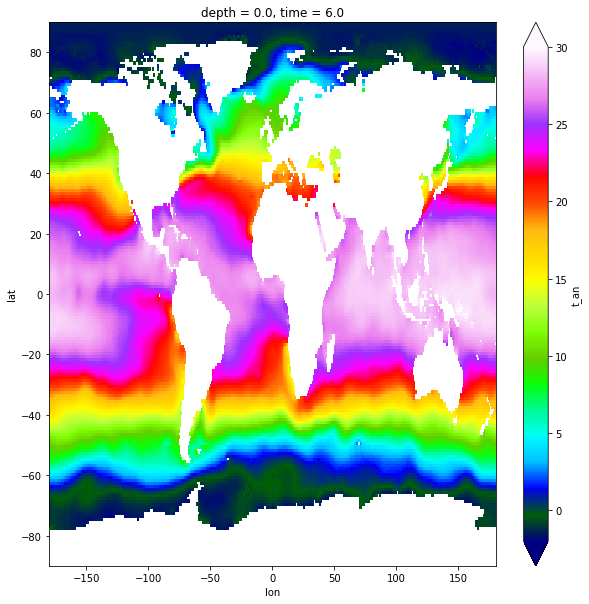

In [8]:
plt.figure(figsize=[10,10])
woa.t_an[0,0,:,:].plot(vmin=-2,vmax=30,cmap=cm.gist_ncar)

In [9]:
# Fortran does not like the NaN from xarray at all !!
# Replace with a special value

tsurf = woa.t_an[0,0,:,:].values
tsurf[np.isnan(tsurf)] = 9999.
tsurf

array([[ 9.9990000e+03,  9.9990000e+03,  9.9990000e+03, ...,
         9.9990000e+03,  9.9990000e+03,  9.9990000e+03],
       [ 9.9990000e+03,  9.9990000e+03,  9.9990000e+03, ...,
         9.9990000e+03,  9.9990000e+03,  9.9990000e+03],
       [ 9.9990000e+03,  9.9990000e+03,  9.9990000e+03, ...,
         9.9990000e+03,  9.9990000e+03,  9.9990000e+03],
       ...,
       [-1.4640100e+00, -1.4661100e+00, -1.4683100e+00, ...,
        -1.4647100e+00, -1.4637101e+00, -1.4613100e+00],
       [-1.4214100e+00, -1.4227101e+00, -1.4250100e+00, ...,
        -1.4223100e+00, -1.4230100e+00, -1.4220101e+00],
       [-1.4182100e+00, -1.4182100e+00, -1.4182100e+00, ...,
        -1.4182100e+00, -1.4182100e+00, -1.4182100e+00]], dtype=float32)

In [10]:
xmsg = 9999              # special value
guess = 1                # guess = 1 zonal mean
gtype = 1                # cyclic or not
nscan = 1500             # usually much less than this
epsx  = 1.e-4            # precision, variable dependent
relc  = 0.6

tsurf_extrp = fill_msg_grid.mod_poisson.poisxy1(tsurf.transpose(),xmsg, guess, gtype, nscan, epsx, relc).transpose()

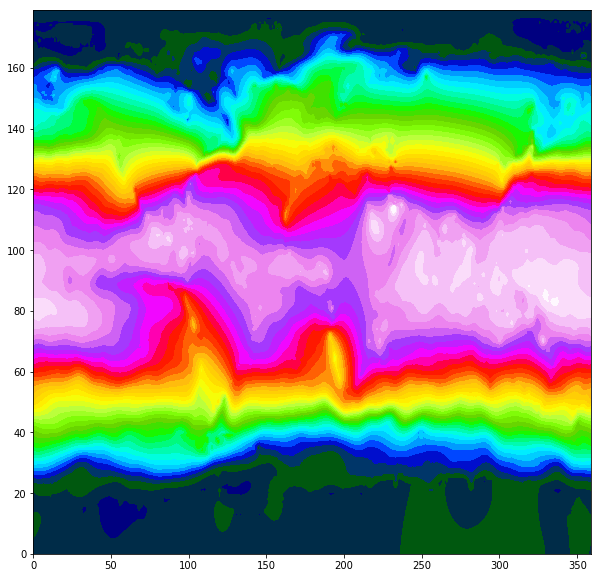

In [11]:
plt.figure(figsize=[10,10])
plt.contourf(tsurf_extrp,50,vmin=-2,vmax=30,cmap=cm.gist_ncar)
plt.show()

## Bonus : including fortran code in python package

In [ ]:
# example from setup.py of PyCNAL_regridding

import os
from numpy.distutils.core import setup, Extension

fill_msg_grid    = Extension(name = 'PyCNAL_regridding.fill_msg_grid',
                             sources = ['PyCNAL_regridding/f90/fill_msg_grid.f90'])
mod_drown_sosie     = Extension(name = 'PyCNAL_regridding.mod_drown_sosie',
                             sources = ['PyCNAL_regridding/f90/mod_drown_sosie.f90'])

setup(
    name = "PyCNAL_regridding",
    version = "1.0",
    author = "Raphael Dussin",
    author_email = "raphael.dussin@gmail.com",
    description = ("A package to create boundary conditions for MOM6 " ),
    license = "LGPLv3",
    keywords = "ocean boundary conditions",
    url = "https://github.com/ESMG/PyCNAL_regridding",
    packages=['PyCNAL_regridding'],
    ext_modules = [fill_msg_grid,mod_drown_sosie]
)